# RehabModel

This notebook loads the combined data, and models the mortality rate.

In [2]:
%matplotlib inline

from bs4 import BeautifulSoup
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import ensemble
from sklearn import linear_model
from sklearn import metrics
from sklearn.externals import joblib
from sklearn.preprocessing import StandardScaler
import scipy as sp
#import seaborn as sns
import requests
import time

In [3]:
with open('DataCombined.json', 'r') as f:
    d = json.load(f);

df = pd.DataFrame(d);
df.index = df.index.astype(int);
df.sort_index(inplace=True);
print df.dtypes
df.head()

County                                                           object
Death Rate Category Median                                      float64
Estimated Age-adjusted Death Rate, 11 Categories (in ranges)     object
FIPS                                                            float64
FIPS State                                                      float64
Opioid Claims                                                   float64
Opioid Prescribing Rate                                         float64
Overall Claims                                                  float64
Part D Prescribers                                              float64
Population                                                      float64
ST                                                               object
State                                                            object
Year                                                            float64
n_facilities                                                    

,County,Death Rate Category Median,"Estimated Age-adjusted Death Rate, 11 Categories (in ranges)",FIPS,FIPS State,Opioid Claims,Opioid Prescribing Rate,Overall Claims,Part D Prescribers,Population,ST,State,Year,n_facilities
14,autauga county,11.0,10.1-12,1001.0,1.0,20482.0,9.803002,208936.0,67.0,55136.0,AL,Alabama,2013.0,0.0
15,autauga county,11.0,10.1-12,1001.0,1.0,20355.0,9.724810,209310.0,67.0,55395.0,AL,Alabama,2014.0,0.0
30,baldwin county,19.0,18.1-20,1003.0,1.0,82517.0,9.151229,901704.0,407.0,195443.0,AL,Alabama,2013.0,16.0
31,baldwin county,19.0,18.1-20,1003.0,1.0,81866.0,9.052919,904305.0,425.0,200111.0,AL,Alabama,2014.0,16.0
46,barbour county,7.0,6.1-8,1005.0,1.0,8935.0,6.278679,142307.0,33.0,26978.0,AL,Alabama,2013.0,0.0


In [4]:
df['Death Rate Category Median'] = df['Death Rate Category Median'].astype(int);
df['FIPS'] = df['FIPS'].astype(int);
df['FIPS State'] = df['FIPS State'].astype(int);
df['Opioid Claims'] = df['Opioid Claims'].astype(int);
df['Overall Claims'] = df['Overall Claims'].astype(int);
df['Part D Prescribers'] = df['Part D Prescribers'].astype(int);
df['Population'] = df['Population'].astype(int);
df['Year'] = df['Year'].astype(int);
df['n_facilities'] = df['n_facilities'].astype(int);
print df.dtypes

County                                                           object
Death Rate Category Median                                        int64
Estimated Age-adjusted Death Rate, 11 Categories (in ranges)     object
FIPS                                                              int64
FIPS State                                                        int64
Opioid Claims                                                     int64
Opioid Prescribing Rate                                         float64
Overall Claims                                                    int64
Part D Prescribers                                                int64
Population                                                        int64
ST                                                               object
State                                                            object
Year                                                              int64
n_facilities                                                    

In [5]:
df['Facility Density'] = df['n_facilities'].values/df['Population']
df.head()
df[df['n_facilities'] > 0]

,County,Death Rate Category Median,"Estimated Age-adjusted Death Rate, 11 Categories (in ranges)",FIPS,FIPS State,Opioid Claims,Opioid Prescribing Rate,Overall Claims,Part D Prescribers,Population,ST,State,Year,n_facilities,Facility Density
30,baldwin county,19,18.1-20,1003,1,82517,9.151229,901704,407,195443,AL,Alabama,2013,16,0.000082
31,baldwin county,19,18.1-20,1003,1,81866,9.052919,904305,425,200111,AL,Alabama,2014,16,0.000080
78,blount county,15,14.1-16,1009,1,9778,6.118784,159803,28,57720,AL,Alabama,2013,2,0.000035
79,blount county,15,14.1-16,1009,1,9769,6.161891,158539,27,57719,AL,Alabama,2014,2,0.000035
110,butler county,9,8.1-10,1013,1,9522,8.188080,116291,35,20289,AL,Alabama,2013,1,0.000049
111,butler county,9,8.1-10,1013,1,9360,8.620372,108580,35,20296,AL,Alabama,2014,1,0.000049
126,calhoun county,11,10.1-12,1015,1,54649,7.984157,684468,276,116547,AL,Alabama,2013,1,0.000009
127,calhoun county,11,10.1-12,1015,1,54179,8.113993,667723,278,115916,AL,Alabama,2014,1,0.000009
142,chambers county,11,10.1-12,1017,1,13724,7.962312,172362,36,34175,AL,Alabama,2013,1,0.000029
143,chambers county,13,12.1-14,1017,1,12542,7.862091,159525,37,34076,AL,Alabama,2014,1,0.000029


In [6]:
df_trim = df.copy();

cols_to_use = ['Opioid Claims', 'Opioid Prescribing Rate',
               'Part D Prescribers', 'Population', 'n_facilities'];

df_trim.head()

,County,Death Rate Category Median,"Estimated Age-adjusted Death Rate, 11 Categories (in ranges)",FIPS,FIPS State,Opioid Claims,Opioid Prescribing Rate,Overall Claims,Part D Prescribers,Population,ST,State,Year,n_facilities,Facility Density
14,autauga county,11,10.1-12,1001,1,20482,9.803002,208936,67,55136,AL,Alabama,2013,0,0.000000
15,autauga county,11,10.1-12,1001,1,20355,9.724810,209310,67,55395,AL,Alabama,2014,0,0.000000
30,baldwin county,19,18.1-20,1003,1,82517,9.151229,901704,407,195443,AL,Alabama,2013,16,0.000082
31,baldwin county,19,18.1-20,1003,1,81866,9.052919,904305,425,200111,AL,Alabama,2014,16,0.000080
46,barbour county,7,6.1-8,1005,1,8935,6.278679,142307,33,26978,AL,Alabama,2013,0,0.000000


In [7]:
x_train = df_trim[df_trim['Year'] == 2013];
x_train = x_train[x_train['n_facilities'] > 0];
y_train = x_train['Death Rate Category Median'];
x_train = x_train[cols_to_use];
#ss = StandardScaler().fit(x_train);
#ss.transform(x_train);

x_test  = df_trim[df_trim['Year'] == 2014];
x_test  = x_test[x_test['n_facilities'] > 0];
y_test  = x_test['Death Rate Category Median'];
x_test  = x_test[cols_to_use];
#ss.transform(x_test);

In [8]:
lr = linear_model.LinearRegression();
lr.fit(x_train[cols_to_use], y_train);
print lr.coef_;
print lr.score(x_train[cols_to_use], y_train);

pred_train = lr.predict(x_train[cols_to_use]);
pred_test = lr.predict(x_test[cols_to_use]);

bins = np.linspace(0,20,11);
bins = np.append(bins, 100);
digitized = 2*np.digitize(pred_test, bins)-1
print np.sqrt(metrics.mean_squared_error(y_test, digitized))

[  1.44807071e-05   1.14719368e+00   5.18773692e-04  -3.80651652e-06
   1.65492749e-02]
0.202215279053
4.49421319237


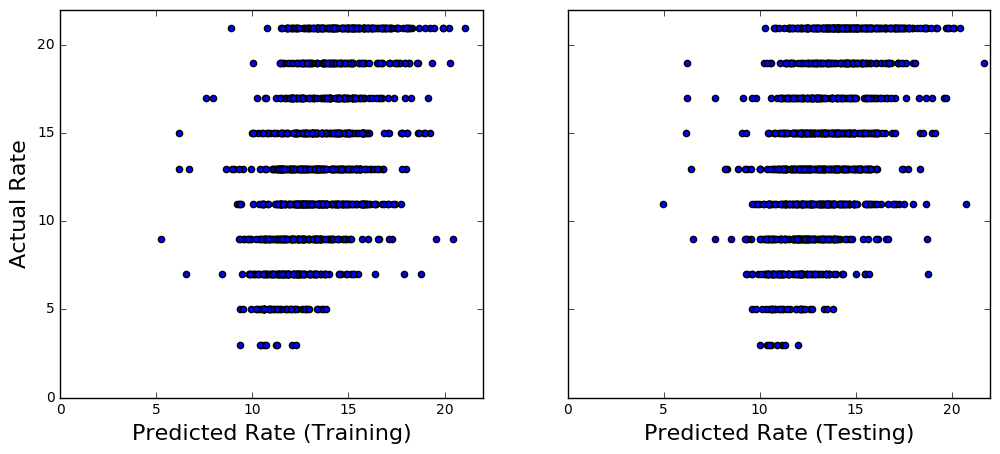

In [9]:
fig, [axL, axR] = plt.subplots(nrows=1, ncols=2, figsize=(12,5), sharey=True);
axL.scatter(pred_train, y_train);
axL.set_xlabel('Predicted Rate (Training)');
axL.xaxis.label.set_fontsize(16);
axL.set_xlim(0,22);
axL.set_ylabel('Actual Rate');
axL.yaxis.label.set_fontsize(16);
axL.set_ylim(0,22);

axR.scatter(pred_test, y_test);
axR.set_xlabel('Predicted Rate (Testing)');
axR.xaxis.label.set_fontsize(16);
axR.set_xlim(0,22);

In [10]:
rf = ensemble.RandomForestRegressor();
rf.fit(x_train[cols_to_use], y_train);
print rf.feature_importances_;

pred_train = rf.predict(x_train[cols_to_use]);
pred_test = rf.predict(x_test[cols_to_use]);

bins = np.linspace(0,20,11);
bins = np.append(bins, 100);
digitized = 2*np.digitize(pred_test, bins)-1
print np.sqrt(metrics.mean_squared_error(y_test, digitized))

[ 0.1938648   0.38789936  0.14684032  0.19416372  0.0772318 ]
3.88398303705


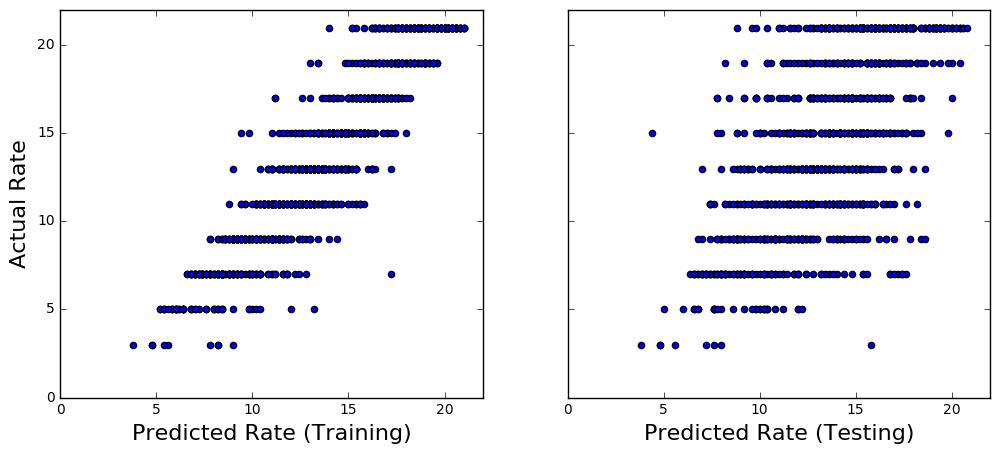

In [11]:
fig, [axL, axR] = plt.subplots(nrows=1, ncols=2, figsize=(12,5), sharey=True);
axL.scatter(pred_train, y_train);
axL.set_xlabel('Predicted Rate (Training)');
axL.xaxis.label.set_fontsize(16);
axL.set_xlim(0,22);
axL.set_ylabel('Actual Rate');
axL.yaxis.label.set_fontsize(16);
axL.set_ylim(0,22);

axR.scatter(pred_test, y_test);
axR.set_xlabel('Predicted Rate (Testing)');
axR.xaxis.label.set_fontsize(16);
axR.set_xlim(0,22);

In [10]:
joblib.dump(rf, 'RehabApp/static/model_rf.pkl')
#joblib.dump(ss, 'RehabApp/static/scale.pkl')

['RehabApp/static/model_rf.pkl',
 'RehabApp/static/model_rf.pkl_01.npy',
 'RehabApp/static/model_rf.pkl_02.npy',
 'RehabApp/static/model_rf.pkl_03.npy',
 'RehabApp/static/model_rf.pkl_04.npy',
 'RehabApp/static/model_rf.pkl_05.npy',
 'RehabApp/static/model_rf.pkl_06.npy',
 'RehabApp/static/model_rf.pkl_07.npy',
 'RehabApp/static/model_rf.pkl_08.npy',
 'RehabApp/static/model_rf.pkl_09.npy',
 'RehabApp/static/model_rf.pkl_10.npy',
 'RehabApp/static/model_rf.pkl_11.npy',
 'RehabApp/static/model_rf.pkl_12.npy',
 'RehabApp/static/model_rf.pkl_13.npy',
 'RehabApp/static/model_rf.pkl_14.npy',
 'RehabApp/static/model_rf.pkl_15.npy',
 'RehabApp/static/model_rf.pkl_16.npy',
 'RehabApp/static/model_rf.pkl_17.npy',
 'RehabApp/static/model_rf.pkl_18.npy',
 'RehabApp/static/model_rf.pkl_19.npy',
 'RehabApp/static/model_rf.pkl_20.npy',
 'RehabApp/static/model_rf.pkl_21.npy',
 'RehabApp/static/model_rf.pkl_22.npy',
 'RehabApp/static/model_rf.pkl_23.npy',
 'RehabApp/static/model_rf.pkl_24.npy',
 'Rehab

(array([  5.49700000e+03,   2.60000000e+02,   1.20000000e+02,
          6.90000000e+01,   4.70000000e+01,   2.70000000e+01,
          3.00000000e+01,   2.50000000e+01,   1.20000000e+01,
          7.00000000e+00,   8.00000000e+00,   5.00000000e+00,
          4.00000000e+00,   2.00000000e+00,   5.00000000e+00,
          3.00000000e+00,   3.00000000e+00,   3.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          2.00000000e+00,   2.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        

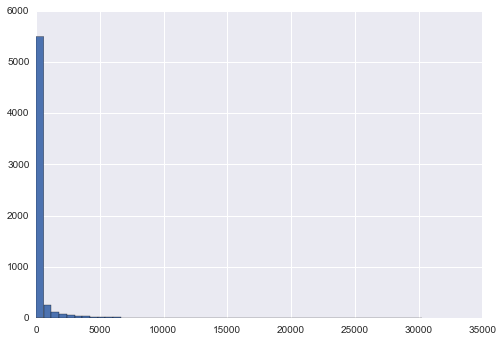

In [11]:
plt.hist(df['Part D Prescribers'].values, bins=50)

In [25]:
2*pred_test-1

array([17, 15, 15, ..., 19, 19, 19])

In [68]:
from bokeh.io import show
from bokeh.models import (
    ColumnDataSource,
    HoverTool,
    LinearColorMapper
)
from bokeh.palettes import Viridis6 as palette
from bokeh.plotting import figure

from bokeh.sampledata.us_counties import data as countydata
from bokeh.sampledata.unemployment import data as unemployment

palette.reverse()

counties = {
    code: county for code, county in countydata.items() if county['state'] == 'tx'#if (county["state"] != "ak" and county['state'] != "hi")
}

county_xs = [county["lons"] for county in counties.values()]
county_ys = [county["lats"] for county in counties.values()]

county_names = [county['name'] for county in counties.values()]
county_rates = []
for county in counties.values():
    mask = ((df_trim['fixcounty'] == fix_county2(county['name'])) &
            (df_trim['ST'] == county['state'].upper()) &
            (df_trim['Year'] == 2013))
    if np.sum(mask) == 0:
        county_rates.append(-1)
    else:
        county_rates.append(df_trim[mask]['Opioid Prescribing Rate'].values[0])
county_rates = np.random.rand(len(counties))
color_mapper = LinearColorMapper(palette=palette)

source = ColumnDataSource(data=dict(
    x=county_xs,
    y=county_ys,
    name=county_names,
    rate=county_rates,
))

TOOLS = "pan,box_zoom,reset,hover,save"

p = figure(
    title="Texas Unemployment, 2009", tools=TOOLS,
    x_axis_location=None, y_axis_location=None
)
p.grid.grid_line_color = None

p.patches('x', 'y', source=source,
          fill_color={'field': 'rate', 'transform': color_mapper},
          fill_alpha=0.7, line_color="white", line_width=0.5)

hover = p.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = [
    ("Name", "@name"),
    ("Unemployment rate)", "@rate"),
    ("(Long, Lat)", "($x, $y)"),
]

show(p)

In [5]:
import bokeh
bokeh.sampledata.download()

Using data directory: /Users/gkafka/.bokeh/data
Downloading: CGM.csv (1589982 bytes)
   1589982 [100.00%]
Downloading: US_Counties.zip (3182088 bytes)
   3182088 [100.00%]
Unpacking: US_Counties.csv
Downloading: us_cities.json (713565 bytes)
    713565 [100.00%]
Downloading: unemployment09.csv (253301 bytes)
    253301 [100.00%]
Downloading: AAPL.csv (166698 bytes)
    166698 [100.00%]
Downloading: FB.csv (9706 bytes)
      9706 [100.00%]
Downloading: GOOG.csv (113894 bytes)
    113894 [100.00%]
Downloading: IBM.csv (165625 bytes)
    165625 [100.00%]
Downloading: MSFT.csv (161614 bytes)
    161614 [100.00%]
Downloading: WPP2012_SA_DB03_POPULATION_QUINQUENNIAL.zip (5148539 bytes)
   5148539 [100.00%]
Unpacking: WPP2012_SA_DB03_POPULATION_QUINQUENNIAL.csv
Downloading: gapminder_fertility.csv (64346 bytes)
     64346 [100.00%]
Downloading: gapminder_population.csv (94509 bytes)
     94509 [100.00%]
Downloading: gapminder_life_expectancy.csv (73243 bytes)
     73243 [100.00%]
Downloading:

In [29]:
def fix_county(word):
    return word.rsplit(' ',1)[0]
df_trim['fixcounty'] = df_trim['County'].apply(fix_county)

In [31]:
mask = (df_trim['fixcounty'] == 'autauga') & (df_trim['ST'] == 'AL') & (df_trim['Year'] == 2013)
df_trim[mask]['Opioid Claims'].values[0]
print counties.keys()

[(48, 337), (48, 43), (48, 133), (48, 287), (48, 489), (48, 67), (48, 221), (48, 439), (48, 1), (48, 155), (48, 373), (48, 463), (48, 89), (48, 307), (48, 397), (48, 103), (48, 241), (48, 331), (48, 37), (48, 191), (48, 265), (48, 483), (48, 125), (48, 215), (48, 417), (48, 59), (48, 149), (48, 367), (48, 505), (48, 83), (48, 301), (48, 391), (48, 17), (48, 235), (48, 325), (48, 479), (48, 169), (48, 259), (48, 413), (48, 119), (48, 193), (48, 347), (48, 53), (48, 143), (48, 281), (48, 499), (48, 77), (48, 295), (48, 433), (48, 11), (48, 229), (48, 383), (48, 457), (48, 163), (48, 317), (48, 407), (48, 97), (48, 251), (48, 341), (48, 47), (48, 185), (48, 275), (48, 493), (48, 71), (48, 209), (48, 427), (48, 5), (48, 159), (48, 361), (48, 451), (48, 93), (48, 311), (48, 385), (48, 27), (48, 245), (48, 335), (48, 473), (48, 179), (48, 269), (48, 487), (48, 113), (48, 203), (48, 421), (48, 63), (48, 137), (48, 355), (48, 87), (48, 289), (48, 443), (48, 21), (48, 239), (48, 377), (48, 467)

In [57]:
def fix_county2(word):
    new_word = word.lower().replace('.', '');
    new_word = new_word.replace('saint','st');
    return new_word

county_rates = []
for county in counties.values():
    mask = ((df_trim['fixcounty'] == fix_county2(county['name'])) &
            (df_trim['ST'] == county['state'].upper()) &
            (df_trim['Year'] == 2013))
    if np.sum(mask) == 0:
        county_rates.append(-1)
    else:
        county_rates.append(df_trim[mask]['Opioid Claims'].values[0])

In [67]:
len(np.random.rand(len(counties)))

254